# Brian Keene | Finite Temperature String Method

In [1]:
##############################
#######  Dependencies ########
##############################
# - matplotlib
# - scipy
# - numpy
# - ffmpeg (for drawing the inline animations; other generic video making modules will suffice)
# - copy (comes default with python)
# - HTML (for drawing the inline animations / comes with Jupyter)
##############################

# put the figures inline
%matplotlib inline

# a variety of tools we'll be using
import matplotlib.pyplot as plt
import copy
import numpy as np 
import scipy as sci
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy import interpolate
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import animation, rc
from IPython.display import HTML

# some parameters we pass to make our matplotlib figures look nice...
# -- see http://blog.juliusschulz.de/blog/ultimate-ipython-notebook
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"

## Define the Müller Potential

The Müller potential is common in theoretical chemistry due to its simple-to-implement analytical expression, multiple minima, and multiple saddle points; the expression for the Müller potential is given by:

\begin{align}
V(x,y) = \sum_{j=1} ^{4} A_j \exp [{ a_j (x - x_{0,j})^2 +  b_j (x - x_{0,j}) (y - y_{0,j}) + 
        c_j (y - y_{0,j})^2} ]
\end{align}

where:

$A_j$ is the parameter governing the depth of potential well $j$ at its minima,

$(x_{0,j}, y_{0,j})$ denotes the location of the minimum of well $j$,

$a_j, b_j \ \text{and} \  c_j$ govern the shape of the respective wells,

$V(x,y)$ is the potential at some arbitrary point $(x,y)$ in the $XY$ plane.

In [2]:
# Müller potential energy surface - parameters

# the depths of our potential wells
A = [-200.0, -100.0, -170.0, 15.0]
# --- we can see that our global minima will be at wells of index == (0 || 2)

# a,b,c define the shape of the wells
a = [-1.0, -1.0, -6.5, 0.7]
b = [0.0, 0.0, 11.0, 0.6]
c = [-10.0, -10.0, -6.5, 0.7]

# x0,y0 combinations define the location of the wells
# here we have wells located at the following (x,y) positions: (1.0, 0.0), (0.0, 0.5), (-0.5, 1.5), and (-1.0, 1.0)
x0 = [1.0, 0.0, -0.5, -1.0]
y0 = [0.0, 0.5, 1.5, 1.0]

# -- from our array of prefactors, we know that the global minima correspond approximately to:
#  (1.0, 0.0) and (-0.5, 1.5)
# -- to see this, just look at the matching indices of each array to get the prefactor, shapes, and positions of 
#    the wells at a given index

In [3]:
# the potential; takes a meshgrid xvals,yvals (see below)
# -- pretty much just used for plotting and visualization...
# -- to do string method on Mueller potential, we only need its gradient
def mueller(xvals,yvals):
    # compute the aval, bval, and cval of the exponential separately
    aval = lambda x, k: a[k] * ((x - x0[k]) ** 2.0)
    bval = lambda x, y, k: b[k] * (x - x0[k]) * (y - y0[k])
    cval = lambda y, k: c[k] * ((y - y0[k]) ** 2.0)
    
    # this computes the actual mueller potential, using the above 
    # lambda functions for a, b, c values
    # refer to the definition of the Mueller potential for further information (see above)
    potential = lambda x, y, k: A[k] * math.exp(aval(x,k) + bval(x,y,k) + cval(y,k))
    
    # xvals, yvals are two arrays... so initialize an array in which we'll put the potentials
    # for each (xval,yval) tuple
    # -- initialize value to zero; then do the four summations
    value = np.zeros((len(xvals),len(yvals)))
    
    # iterate over the xvals, yvals; and then compute the potential
    for index, item in enumerate(xvals):
        for index2, item in enumerate(yvals):
            thisVal = 0.0
            for j in range(4):

                thisVal += potential(xvals[index][index2],yvals[index][index2],j)
            value[index][index2] = thisVal
        
    # return our array of the potential
    return value


# derivative of our mueller potential; 
# takes a single point x and a single point y as single array - nominally here 'coordinates'
# returns the gradient at that point;
def muellerDerivative(coordinates):
    xval = coordinates[0]
    yval = coordinates[1]
    
    aval = lambda x, k: a[k] * ( ( x - x0[k]) ** 2.0)
    bval = lambda x, y, k: b[k] * (x - x0[k]) * (y - y0[k])
    cval = lambda y, k: c[k] * ((y - y0[k]) ** 2.0)
    
    potential = lambda x, y, k: A[k] * math.exp(aval(x,k) + bval(x,y,k) + cval(y,k))
    
    # pre-factor that arises when we take d/dx(V(x,y))
    xprime = lambda x, y, k: 2.0 * a[k] * (x - x0[k])  + b[k] * (y - y0[k])
    
    # pre-factor that arises when we take d/dy(V(x,y))
    yprime = lambda x, y, k: 2.0 * c[k] * (y - y0[k]) + b[k] * (x - x0[k])
    
    value = [0.0, 0.0]
    
    for j in range(4):
        potentialValue = potential(xval,yval,j)
        value[0] += xprime(xval,yval,j) * potentialValue
        value[1] += yprime(xval,yval,j) * potentialValue
    
    return value
    

In [4]:
# let's take some samples of the mueller potential

# we'll have samples = (rootsamples) ** 2.0 number of samples at the end
rootsamples = 300
xvals = np.linspace(-1.5,1.2,rootsamples)
yvals = np.linspace(-0.2,2.0,rootsamples)

zvals = np.zeros((rootsamples,rootsamples))

xvals, yvals = np.meshgrid(xvals, yvals)
zvals = mueller(xvals,yvals)

##### Parameters to toy around with
Feel free to modify 'numberOfContours' and 'truncateAtValue' - this will change the contour plot below without modifying data stored about the potential.

numberOfContours = the number of contours displayed on the plot

truncateAtValue = the value of the potential at which we simply set it to this value; i.e., we truncate all values 
such that any value of the potential greater than 'truncateAtValue' is set to 'truncateAtValue'. This allows for us to maintain resolution with respect to the wells (the parts of the potential which we care about), since the potential rises expontentially as we deviate from the potential wells.

In [5]:
# number of contour lines;  good value is ~ 50.
numberOfContours = 50

# value at which we truncate our potential energy associated with a given point (x,y)
# good value is ~ 150.0
truncateAtValue = 150.0

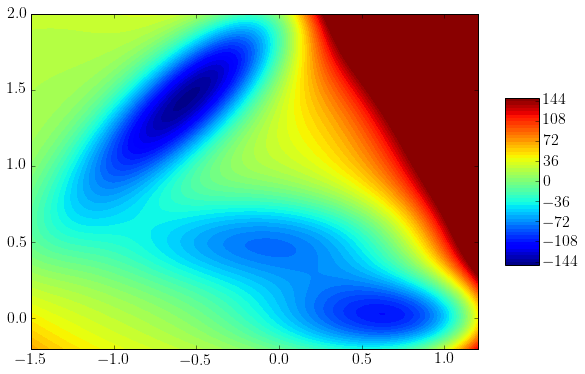

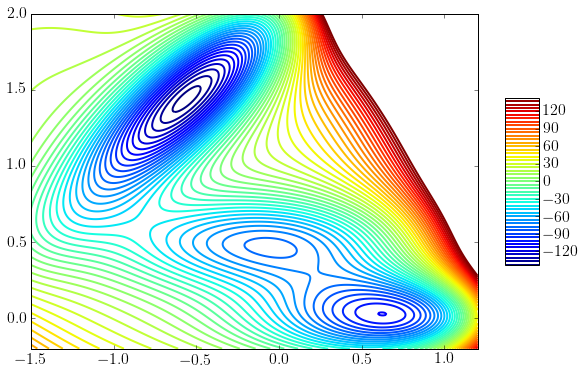

In [6]:
# make a copy of zvals, so that we can toy around with our truncation
zvalsToPlot = copy.copy(zvals);

# the potential goes as an exponential, and we don't particularly care about the higher
# values... so, truncate it at a potential of 'truncateAtValue' so that we can get some good resolution
# regarding the potential wells.  

# typically, values of ~50 contours and truncate value of ~150.0 seem to give nice pictures.

for xIndex, xval in enumerate(zvals):
    for yIndex, yval in enumerate(zvals):
        zvalsToPlot[xIndex][yIndex] = min(zvals[xIndex][yIndex],truncateAtValue)

fig = plt.figure();
surface = plt.contourf(xvals,yvals,zvalsToPlot,numberOfContours,label='Mueller Potential');
plt.colorbar(surface, shrink=0.5, aspect=5);

# and just another plot of the same thing to illustrate the contours more clearly...
fig = plt.figure();
surface = plt.contour(xvals,yvals,zvalsToPlot,numberOfContours,linewidth=(3,))
plt.colorbar(surface,shrink=0.5,aspect=5);

## Creating a String to Sample A Potential

We'll pretend that a heatmap of the potential energy surface is, in fact, not directly above the title of this section.  Let's assume that we do not know a-priori the surface we wish to explore; instead, we know only some reasonable bounds on the domain we wish to explore (where domain may be in configuration space, or it could be in terms of our collective variables).  


For instance, let's assume that we know that all points of the string lie somewhere in the domain on which we defined our potential:

$x \in [-1.5, 1.2]$ and $y \in [-0.2, 2.0]$ for the Müller potential above (this was the domain on which we took samples of the potential).


We now wish to initialize points on our string within this domain - pretend that we do not know where the potential wells are, and see if the string converges to the Minimum Free Energy Path (MFEP) connecting the potential wells 
(this path is represented by the light blue trail linking the dark blue minima).

In [7]:
# class that describes a given replica 
# --- we are primarily concerned with monitoring the current coordinates, and the average position of a given 
#     replica; we make store this data here
class Replica:
    def __init__(self, initialCoordinates_):
     
        # makes this easy to generalize to higher dimensions later, if this is desired
        self.coordinates = np.array(initialCoordinates_)
        
        # give a dummy value to previous coordinates, just to initialize the variable
        self.previousCoordinates = np.array(initialCoordinates_)
        
        # number of samples over which we have computed the running average position
        self.numberOfSamples = 0.0
        
        # initialize the running sum of the position.. to get the running avg, we would then divide by 
        # the number of samples that have contributed to this sum
        self.coordinatesRunningSum = np.zeros((len(self.coordinates)))
        
        self.averagePosition = np.zeros((len(self.coordinates)))
        
    def setCoordinates(self,newCoordinates):
        self.coordinates = np.array(newCoordinates)
        
    def getCoordinatesBeforeUpdate(self):
        # store these coordinates - we are about to attempt an update
        self.__storeCoordinates()
        return self.coordinates
        
    def getCoordinates(self):
        # we just want the coordinates - not updating
        return self.coordinates
    
    # store the current coordinates
    def __storeCoordinates(self):
        self.previousCoordinates = self.coordinates
        
    def resetCoordinates(self):
        self.coordinates = self.previousCoordinates
    
    def getRunningAveragePosition(self):
        return self.averagePosition
    
    def computeRunningAveragePosition(self):
        self.numberOfSamples += 1.0
        self.coordinatesRunningSum += self.coordinates
        
        self.averagePosition = self.coordinatesRunningSum / self.numberOfSamples

In [8]:
# class that describes a given image on our string
class Image: 
    def __init__(self,initialCoordinates_):
        
        # initial the coordinates to those passed in
        self.coordinates = np.array(initialCoordinates_)
        self.allCoordinatesList = []
        
    def getCoordinatesBeforeUpdate(self):
        self.__storeCoordinates()
        return self.coordinates
    
    def getCoordinates(self):
        return self.coordinates
    
    def __storeCoordinates(self):
        self.previousCoordinates = self.coordinates
        
    def getOldCoordinates(self):
        return self.previousCoordinates
    
    def setCoordinates(self,newCoordinates):
        self.coordinates = np.array(newCoordinates)

In [9]:
# define a class, PrincipalCurve, that will have images ( (x,y) tuples) along some discrete curve; each image will
# have a 'simulation' or 'walker' associated with it;

# a brief function computing N-dimensional Euclidean distance between two sets of coordinates
def distance(coordinates1, coordinates2):
    squaredDisplacement = 0.0
    for i in range(len(coordinates1)):
        squaredDisplacement += ( (coordinates1[i] - coordinates2[i]) ** 2.0)
    thisDistance = np.sqrt(squaredDisplacement)
    return thisDistance
        

# our principal curve class;
class PrincipalCurve:
    
    # on initialization of a PrincipalCurve object, we require the number of images and the line on which 
    # these images will be initialized
    def __init__(self,numberOfImages_, initial_position_alpha_0, initial_position_alpha_N):
        
        self.numberOfImages = numberOfImages_
        
        # dimensionality of the coordinates passed in (currently, this notebook is designed only for 2D potentials)
        # but this would make generalizing to higher dimensions helpful
        self.dimensionality = len(initial_position_alpha_0)
        
        self.x0 = initial_position_alpha_0[0]
        self.y0 = initial_position_alpha_0[1]
        
        self.xN = initial_position_alpha_N[0]
        self.yN = initial_position_alpha_N[1]
        
        # some parameters for updating our images along the string
        self.deltaTau = 0.1
        self.kappaN = 0.1 * self.numberOfImages * self.deltaTau
        
        # create a number of images initialized along the line defined above
        self.__createImages();
        
        # create a replica located on each image
        self.__createReplicas();
        
        # list of images, list of replicas, list of average positions, 
        # and list of splines (all for plotting our evolution)
        self.listOfImages = []
        self.listOfReplicas = []
        self.listOfAveragePositions = []
        self.listOfSplines = []
        
    # this function creates a number of images 'N' that are distributed equidistantly across the line
    # from (x0,y0) to (xN,yN)
    def __createImages(self):
                
        # get the range of (X,Y) across which we will lay our initial string
        totalXRange = self.xN - self.x0
        totalYRange = self.yN - self.yN
        
        # get the delta x, delta y value between each adjacent image
        # since we place our image alpha=0 at the initial coordinates, we divide up the line from 0 to N by 
        # N-1 images... do that here:
        deltaX = totalXRange / (self.numberOfImages - 1)
        deltaY = totalYRange / (self.numberOfImages - 1)
        
        # initial positions (position of image at alpha = 0)
        initial_x_pos = self.x0
        initial_y_pos = self.y0
        
        # the list of images that comprise our string
        self.images = []
        
        # for alpha = 0, 1, ... , N, create an image
        for alpha in range(self.numberOfImages):
            # create the position corresponding to this alpha index
            xpos = initial_x_pos + (alpha * deltaX)
            ypos = initial_y_pos + (alpha * deltaY)

            # create our image at this point
            self.images.append(Image([xpos,ypos]))
    
    # this function creates the replica associated with a given image;
    def __createReplicas(self):
        self.replicas = []

        # at this point, we've already created our images... and each image has a coordinate.
        # with each image, associate a replica
        for image in self.images:
            # get the coordinates of this image..
            initialCoordinates = image.getCoordinates()
            
            # and create a replica at this position
            self.replicas.append(Replica(initialCoordinates))
    
    # this function finds the closest image on our string, given some coordinates, and returns the index
    def findClosestImage(self, replicaCoordinates):
        distances = np.zeros((self.numberOfImages))
        # loop over all images, and compute the distance between replicaCoordinates and this image's coordinates
        for i in range(self.numberOfImages):
            imageCoordinates = self.images[i].getCoordinates()
            distances[i] = distance(replicaCoordinates,imageCoordinates)
        # return the index of the minimum value in our distances array
        return np.argmin(distances)
        
    # this function updates the images after a given number of steps (we do it after each step here) to be 
    # closer to the running average position of its replica, with some smoothing constraints
    def updateImages(self):
        for index, image in enumerate(self.images):
            currentCoordinates = image.getCoordinatesBeforeUpdate()
            replicaRunningAverage = self.replicas[index].getRunningAveragePosition()
            smoothingTerm = self.__computeSmoothingTerm(index)
            
            newCoordinates = currentCoordinates - self.deltaTau * (currentCoordinates - replicaRunningAverage)
            newCoordinates += smoothingTerm
            image.setCoordinates(newCoordinates)
    
    # computes the smoothing term x* (this is r* in the paper, see section 2A part (3) of algorithm)
    def __computeSmoothingTerm(self, index):
        # this term is zero for the ends of the string
        if (index == 0 or index == (self.numberOfImages-1)):
            return np.zeros(self.dimensionality)
        
        nextImageCoordinates = self.images[index+1].getCoordinates()
        previousImageCoordinates = self.images[index-1].getCoordinates()
        imageCoordinates = self.images[index].getCoordinates()

        xStarAlpha = self.kappaN * (nextImageCoordinates + previousImageCoordinates - 2.0 * imageCoordinates)
        return xStarAlpha
        
    # this function uses cubic splines to interpolate between subsequent images;
    # we then compute the arc length of this interpolation, and redistribute the images at equal 
    # distance along the string
    def reparameterizeString(self):
        xPosList = []
        yPosList = []
        for image in self.images:
            theseCoordinates = image.getCoordinates()
            xPosList.append(theseCoordinates[0])
            yPosList.append(theseCoordinates[1])
            
        # we now have our array of coordinates through which we wish to do an interpolation...
        # --- use cubic splines to interpolate between successive images
        
        # BEFORE
        self.currentSpline, self.u = interpolate.splprep([xPosList, yPosList],s=0)

        # AFTER
        # self.currentSpline, self.u = interpolate.splprep([xPosList, yPosList])
        # get the total contour length of our interpolated string...
        self.__computeStringTotalArcLength()
    
        # now, we need to do some root finding to re-distribute our images such that they are 
        # equidistant in XY-space rather than in our parameter space 'u';
        # our 'u' parameters are stored in self.u, if you'd like to print them out; ranging from [0, 1] uniformly
        # but we want our uniformity to be in the arc lengths between successive images.

        # get the arc length that we will have between successive images in XY-space
        # -- we have 'N' images with 'N-1' lengths between them
        self.arcLengthBySection = self.arcLength / (self.numberOfImages - 1)
        
        # do some root finding, beginning with our end point located at self.u[0], and get the u-value 
        # associated with the XY-coordinate along our B-Spline that preserves equal arcLength
        self.uValsNew = []
        
        # our initial image of the string is not perturbed by the reparameterization process
        self.uValsNew.append(self.u[0])
        
        resolution = self.u[1] - self.u[0]; # displacement from our lowerbound (an ok guess)
        # subtract 2 values, because we don't move the first or last images on our string.
        for i in range(len(self.u) - 2):
            # the lowerBound of integration is the position of our image in u-space which has already been 
            # reparameterized; it is our image at self.uValsNew[i]
            self.lowerBound = self.uValsNew[i]
            guess = self.lowerBound + resolution
            nextValue = sci.optimize.fsolve(self.__arcLengthMinimization,guess)
            self.uValsNew.append(nextValue)
            
        # and append our last u-value, since the final image does not move either
        self.uValsNew.append(self.u[-1])
        
        # compute the XY positions associated with our new 'u' parameter values
        newCoords = interpolate.splev(self.uValsNew, self.currentSpline)
        
        # assign them to our images;
        # get the RMS displacement of our images (how far they moved this turn), as this is our convergence criterion
        #    just while we're already in this loop
        self.rmsd = 0.0;
        for i in range(len(newCoords[:][0])):
            xpos = newCoords[0][i]
            ypos = newCoords[1][i]
            coordinatesAtStartOfTurn = self.images[i].getOldCoordinates()
            self.images[i].setCoordinates([xpos,ypos])
            displacement = distance( [xpos,ypos], coordinatesAtStartOfTurn)
            self.rmsd += (displacement ** 2.0)
        
        # get the average squared displacement..
        self.rmsd = (self.rmsd / self.numberOfImages)
        # and take our square root
        self.rmsd = np.sqrt(self.rmsd)
        # and we're done with our reparamaterization
    
    # this function computes the total arc length 
    def __computeStringTotalArcLength(self):
        arcLength = 0.0
        self.arcLength = 0.0
        numberOfPoints = 3 #
        # further discretize to get better accuracy, especially around points of high curvature
        for i in range(len(self.u) - 1):
            lowerBound = self.u[i]
            upperBound = self.u[i+1]
            uvals = np.linspace(lowerBound,upperBound,numberOfPoints)
            for j in range(len(uvals) - 1):
                arcLength, error, out = sci.integrate.quad(self.__arcOfSpline, uvals[j],uvals[j+1],full_output=1)
                self.arcLength += arcLength
        #print "computed self.arcLength: ",self.arcLength
        
    def __derivativeOfSpline(self, uval):
        thisDerivative = interpolate.splev(uval,self.currentSpline,der=1)
        return thisDerivative
    
    def __arcOfSpline(self,uval):
        derivs = self.__derivativeOfSpline(uval)
        dxdu = derivs[0]
        dydu = derivs[1]
        value = np.sqrt( (dxdu ** 2.0) + (dydu ** 2.0))
        return value
    
    def __arcLengthMinimization(self,guess):
        # discretize our guess, and then we'll integrate the little pieces of it
        uvals = np.linspace(self.lowerBound,guess,10)
        totalArcLength = 0.0
        for j in range(len(uvals) - 1):
            thisArcLength, errorEval, out = sci.integrate.quad(self.__arcOfSpline,uvals[j],uvals[j+1],full_output=1)
            totalArcLength += thisArcLength
        return totalArcLength - self.arcLengthBySection
    
    # this function makes a list of the current positions of our images, 
    # and returns these as separate lists xPositions, yPositions
    def getAllImageCoordinates(self):
        xPositions = []
        yPositions = []
        
        for image in self.images:
            theseCoordinates = image.getCoordinates()
            xPositions.append(theseCoordinates[0])
            yPositions.append(theseCoordinates[1])
            
        return xPositions, yPositions
    
    #
    # getters and setters for aggregate data holders.. nothing interesting below here
    #
    
    def storeImages(self):
        dataToSave = copy.deepcopy(self.images)
        self.listOfImages.append(dataToSave)
        
    def storeReplicas(self):
        dataToSave = copy.deepcopy(self.replicas)
        self.listOfReplicas.append(dataToSave)
        
    def storeSpline(self):
        dataToSave = copy.deepcopy(self.currentSpline)
        self.listOfSplines.append(dataToSave)

    def storeAveragePositions(self):
        listOfAveragePositions = []
        for i in range(self.numberOfImages):
            listOfAveragePositions.append(self.replicas[i].getRunningAveragePosition())
        dataToSave = copy.deepcopy(listOfAveragePositions)
        self.listOfAveragePositions.append(dataToSave)
    
    def getListOfImages(self):
        return self.listOfImages
    
    def getListOfReplicas(self):
        return self.listOfReplicas
    
    def getListOfSplines(self):
        return self.listOfSplines
    
    def getListOfAveragePositions(self):
        return self.listOfAveragePositions
    
    def getRMSD(self):
        return self.rmsd # the current rmsd from last turn to this turn of our images on the string

## The Finite Temperature String Algorithm

We now have a potential and some infrastructure with which we can implement the Finite Temperature String method to sample the Müller potential.  We have our potential and its gradient; a principal curve, composed of images; and with each image, we have associated a replica.

Now, referring to 

[ E. Vanden-Eijnden and M. Venturoli, J. Chem. Phys. $\textbf{130}$, 194103 (2009) ]

we implement the following algorithm:

### Initialization:

#### (1) 
Begin with an initial set of images $\mathbf{\varphi}_\alpha ^0$, with  $\alpha = 0, ..., N$ with images placed such that the arc length between all pairs of sequential images is equal.

#### (2) 
Associate with each image a replica of the system. (In this simple example, where we have images placed along a line in the X-Y plane, this amounts to placing a point at the X-Y coordinate of the image)


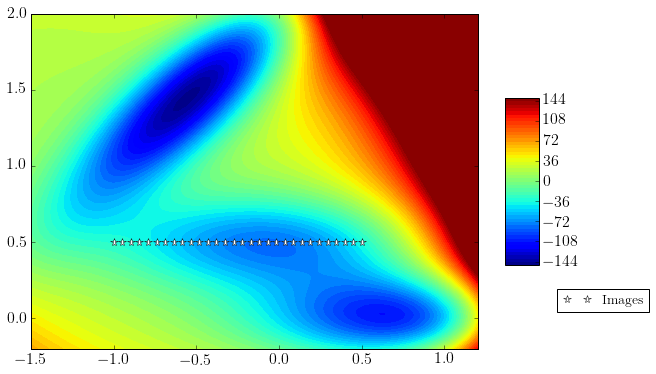

In [10]:
# create our set of images, and with each we associate a replica..
# -- we need to decide what our initial curve looks like, i.e. give it some domain in the XY plane on 
#    which it resides;
#    A decent first guess might be a curve going from (x0, y0) = (0.5, 1) to (-0.5, 1)
#    -- "decent first guess" is obtained by looking at the picture above and pretending we don't know the /exact/
#       location of the minima... just to keep things interesting
#    -- realistically, we could put our curve anywhere we like, since the gradient of the potential is defined 
#       everywhere; but, we'll put it close to our wells just so that it converges quickly and we don't waste time


# we'll pick some number of images with which we'll discretize our curve
# -- recall: alpha goes from 0, 1, ..., N; let's say we want N = 20; then we have 21 images
numberOfImages = 30

# our initial coordinates for alpha = 0 and alpha = N; we will do a linear interpolation for all other images 
# between them
initial_position_alpha_0 = [-1.0, 0.5]
initial_position_alpha_N = [0.5, 0.5]

# create a String on which we will implement the FTS method on the Mueller potential
FTS_String = PrincipalCurve(numberOfImages, initial_position_alpha_0, initial_position_alpha_N)

# and we're done setting up our images; 
# note that in the initialization of our images of the principal curve, we already set up the 
# replicas that correspond to each image (refer to the PrincipalCurve class __init__ function).

# returns the x and y positions associated with all images of our string
imagesToPlotX, imagesToPlotY = FTS_String.getAllImageCoordinates();

# let's overlay our curve on our Mueller potential:
fig = plt.figure();
surface = plt.contourf(xvals,yvals,zvalsToPlot,numberOfContours,label='Mueller Potential');
plt.colorbar(surface, shrink=0.5, aspect=5);
initialString = plt.plot(imagesToPlotX, imagesToPlotY,'*w',label='Images',linewidth=3)
plt.legend(['Images'], bbox_to_anchor = (1.4,0.2));

### Iteration:

#### (1) 
Integrate the equations of motion to obtain a new position for each replica $\textbf{r}_\alpha$, where it is understood that a replica can be defined by its position in XY space (this can later be generalized to its position in collective variable space); if a replica $\mathbf{r}_{\alpha}$ moves such that the closest image $\mathbf{\varphi}_{\alpha}$ is some $\alpha ' \neq \alpha$, reject the move and put the replica back at its original position.

We use Langevin dynamics for this simulation, although any thermostatting method (excluding Dissipative Particle 
Dynamics) may be used with the Finite Temperature String method.

Langevin Dynamics may be expressed as follows:

\begin{align}
\frac{ \partial \mathbf{x}}{\partial t} = - \nabla V(\mathbf{x}) + \sqrt{2 \beta ^{-1}} 
            \mathbf{\xi}
\end{align}


#### (2) 
Compute the running average position of each respective replica: 
\begin{align}
\overline{\mathbf{r}}_\alpha ^n  = \frac{1}{n} \sum_{n' = 0} ^n \mathbf{r}_\alpha ^{n'}
\end{align}

#### (3) 
Move each image of the string towards the running average position of its respective replica.  In doing so, we require that the string remain somewhat smooth, and so we implement constraints on the images $\alpha = 1, ... , N-1$. The updating scheme is as follows:

\begin{align}
\boldsymbol{\varphi}_\alpha ^{\star} = 
        \boldsymbol{\varphi}_\alpha ^{n} - \Delta \tau (
        \boldsymbol{\varphi}_\alpha ^{n} - \overline{\mathbf{r}}_\alpha ^{n} ) + \mathbf{x}^{\star}
\end{align}

\begin{align}
\Delta \tau \approx 0.1
\end{align}

\begin{align}
\mathbf{x}_0 ^\star = \mathbf{x}_N ^\star = 0
\end{align}

\begin{align}
\mathbf{x}_\alpha ^\star = \kappa ^n ( 
        \boldsymbol{\varphi}_{\alpha + 1} ^\star + 
        \boldsymbol{\varphi}_{\alpha - 1} ^\star - 
        2 \boldsymbol{\varphi}_{\alpha} ^\star) ,\ \alpha = \{1, ..., N-1\}
\end{align}


\begin{align}
\kappa ^n = \kappa N \Delta \tau, \ \kappa \approx 0.1
\end{align}

Here, $\mathbf{x}_\alpha ^\star$ is a translation of a given image which we use to keep the string smooth;
$\kappa$ is a parameter that controls that smoothing process (where a larger $\kappa$ value denotes a more aggressive smoothing); and $\Delta \tau$ is a parameter that can be understood to control the sluggishness of the movement of our image towards the running average position of its replica.

#### (4)
Reparameterize the string such that the images are distributed at equal distance along the curve;
This is done by interpolating a curve through the current position of the images, computing the contour length of the entire string, and dividing this in to N equal lengths.  We then place the images at these new points along our string.

#### (5) 
Compute the distance for each replica $\mathbf{r}_\alpha$, and verify that the closest image for each $\mathbf{r}_\alpha$ is $\mathbf{\varphi}_\alpha$;  if the closest image is some $\mathbf{\varphi}_{\alpha '}$ such that $\alpha ' \neq \alpha$, then place the replica $\mathbf{r}_\alpha$ identically at the position of its image $\mathbf{\varphi}_{\alpha}$; after this verification is complete, return to step (1) of the iteration and repeat until convergence of the images (i.e., the images remain in place below some tolerance)


In [11]:
# we'll use a Langevin scheme to perform our MD integration

# let's make a counter to see how many steps it takes for our string to converge
numSteps = 0;

# timestep of 0.0001
dt = 0.0001

# 1 / beta = kT ... so betaInverse is kT. smaller betaInverse --> closer to MEP we converge
# -- we can verify the free-energy integration by setting betaInverse to zero
betaInverse = 1.0

# assign our potential and its derivative to general variables "potential" and "force"
# -- this is not at all necessary, but will hopefully make the code more readable in the iteration below
potential = mueller
force = muellerDerivative

# initialize the root mean square displacement (rmsd) to some large number.. this will get recomputed at 
# every single iteration anyways
# the root mean square displacement refers to the average absolute displacement of our set of images at a given step
# ----> at convergence, this approaches zero
rmsd = 10000000;

# maximum number of steps we're willing to take
maxAllowedSteps = 100;

# we want our string to be converged... so the  root mean square deviation from one step to the 
# next of our images should be near zero, which indicates that the average position in each cell has converged.
tolerance = 1 * (10.0 ** -5)

# first, compute the running average position of our replicas... (just for initialization)
for i in range(numberOfImages):
    FTS_String.replicas[i].computeRunningAveragePosition()

nsteps = 0

In [12]:
# our iterative algorithm
converged = True # boolean flag; tripped to false if maxAllowedSteps is exceeded
while (rmsd > tolerance):
    
    #### step 0: save data for visualization later :)
    
    ####################################################################################
    ### save data for animations, before we move anything ###
    ####################################################################################
    FTS_String.storeImages()
    FTS_String.storeReplicas()
    
    
    #### step 1: integrate the equations of motion to get a new trial position for each replica
    for i in range(numberOfImages):
        # grab our replica at this index
        thisReplica = FTS_String.replicas[i]
        
        # get our current coordinates of the replica, and save our old ones
        coordinates = thisReplica.getCoordinatesBeforeUpdate()
        
        # get our gaussian random numbers for x, y displacement
        xi_x, xi_y = [np.random.normal(), np.random.normal()]
        
        # compute the force exerted by our potential
        forces = force(coordinates)
        
        # update the x and y positions
        xPosition = coordinates[0] - dt * forces[0] + np.sqrt(2.0 * betaInverse * dt) * xi_x
        yPosition = coordinates[1] - dt * forces[1] + np.sqrt(2.0 * betaInverse * dt) * xi_y

        newCoordinates = [xPosition, yPosition]
        
        # set the coordinates of the replica to the updated positions
        thisReplica.setCoordinates(newCoordinates)
        
        # find the index associated with the closest image on our string...
        thisIndex = FTS_String.findClosestImage(newCoordinates)
        
        # if the closest image is not the image associated with this replica, the move is rejected! 
        # else, we accept the move and move on
        if (thisIndex != i):
            thisReplica.resetCoordinates()
    
    #### step 2: compute the running average position of each replica
    for i in range(numberOfImages):
        thisReplica = FTS_String.replicas[i]
        thisReplica.computeRunningAveragePosition()
        
    #### step 3: update the images along the string, subject to smoothing
    FTS_String.updateImages()
    
    #### step 4: re-parameterize our string, enforcing equal arc length
    ####         -- this is actually fairly complicated
    FTS_String.reparameterizeString()
    
    #### step 5: enforce the condition that all replicas are in the correct voronoi cell
    for i in range(numberOfImages):
        thisReplica = FTS_String.replicas[i]
        thisImage = FTS_String.images[i]
        
        coordinates = thisReplica.getCoordinates()
        
        thisIndex = FTS_String.findClosestImage(coordinates)
        
        if (thisIndex != i):
            thisReplica.setCoordinates(thisImage.getCoordinates())
    
    # update our rmsd (just to evaluate our convergence criterion - the images have more or less ceased to move)
    rmsd = FTS_String.getRMSD();
    
    # lastly, 
    nsteps += 1
    
    ################
    # More saving stuff -- but, just stuff that we don't have at the beginning of an iteration
    ################
    FTS_String.storeSpline()
    FTS_String.storeAveragePositions()
    
    
    if nsteps > maxAllowedSteps:
        converged = False
        break
    if ( (nsteps%50) == 0 ):
        print "Currently at MD step: ", nsteps, " with rmsd ", rmsd 

        
        
        
#####
# one last call to our save data functions, just to store the final state of the system... and then add a step, 
# just because
#####
FTS_String.storeImages()
FTS_String.storeReplicas()
FTS_String.storeSpline()
FTS_String.storeAveragePositions()
nsteps += 1
if (converged):
    print "String has converged - execute next cells to render movies and view animations."
else:
    print "rmsd remained above tolerance, but steps taken exceeded maxAllowedSteps.\n"
    print "Data was saved, but convergence is not guaranteed."

Currently at MD step:  50  with rmsd  0.00232359572738
Currently at MD step:  100  with rmsd  0.0010301326468
rmsd remained above tolerance, but steps taken exceeded maxAllowedSteps.

Data was saved, but convergence is not guaranteed.


In [13]:
# retrieve all data we wish to plot

# get the list of our images as they evolve through the MD steps
listOfAllImages = FTS_String.getListOfImages()

# get the list of our replicas as they evolve through the MD steps
listOfAllReplicas = FTS_String.getListOfReplicas()

# get the list of our splines for each step
listOfSplines = FTS_String.getListOfSplines()

# get the list of replica average positions as they evolve through the MD steps
listOfAveragePositions = FTS_String.getListOfAveragePositions()

In [ ]:
numFigs = 0

fig, ax = plt.subplots()

print "This could be a while! Making html5 video with number of frames: ", nsteps-1
ims = []

# our base image is always the contourf: our heat map of the mueller potential
im = ax.contourf(xvals,yvals,zvalsToPlot,numberOfContours)
add_arts = im.collections

for i in range(nsteps-1):
    # get the 'images' on our string at this step..
    images = listOfAllImages[i]
    xcoords = []
    ycoords = []
    for image in images:
        coords = image.getCoordinates()
        xcoords.append(coords[0])
        ycoords.append(coords[1])
    imagesAtThisFrame, = ax.plot(xcoords, ycoords,'*w',label='Images',linewidth=3)
    ims.append(add_arts + [imagesAtThisFrame])

print "making animation..."
ani = animation.ArtistAnimation(fig, ims);

print "making html5 video..."
HTML(ani.to_html5_video())

In [14]:
print nsteps
#####################################################
########## And, some plotting animations ############
#####################################################

# First set up the figure, the axis, and the plot element we want to animate
#fig, ax = plt.subplots()

#ax.set_xlim(( 0, 2))
#ax.set_ylim((-2, 2))


#surface = plt.contourf(xvals,yvals,zvalsToPlot,numberOfContours,label='Mueller Potential');
#plt.colorbar(surface, shrink=0.5, aspect=5);
#initialString = plt.plot(imagesToPlotX, imagesToPlotY,'*w',label='Images',linewidth=3)
#plt.legend(['Images'], bbox_to_anchor = (1.4,0.2));

#fig = plt.figure();
#surface = plt.contourf(xvals,yvals,zvalsToPlot,numberOfContours,label='Mueller Potential');
#plt.colorbar(surface, shrink=0.5, aspect=5);

#line, = ax.plot([], [], lw=2)

#def init():
#    line.set_data([], [])
#    return (line,)

# animation function. This is called sequentially
#def animate(i):
#    x = np.linspace(0, 2, 1000)
#    y = np.sin(2 * np.pi * (x - 0.01 * i))
#    line.set_data(x, y)
#    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
#anim = animation.FuncAnimation(fig, animate, init_func=init,
#                               frames=100, interval=20, blit=True)
#HTML(anim.to_html5_video())

102


done
0.00101945204045


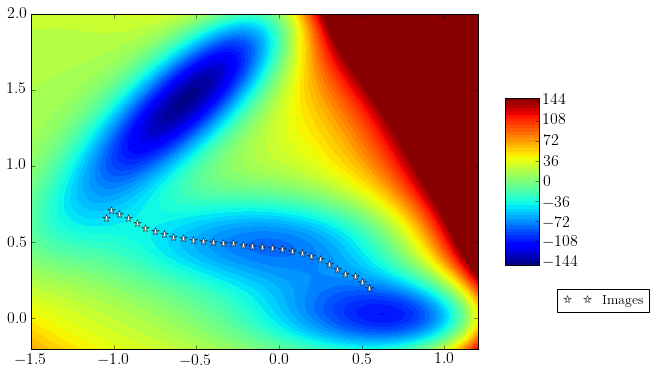

In [15]:

###################################################
## delete this when done testing...
###################################################
# returns the x and y positions associated with all images of our string
imagesToPlotX, imagesToPlotY = FTS_String.getAllImageCoordinates();

# let's overlay our curve on our Mueller potential:
fig = plt.figure();
surface = plt.contourf(xvals,yvals,zvalsToPlot,numberOfContours,label='Mueller Potential');
plt.colorbar(surface, shrink=0.5, aspect=5);
initialString = plt.plot(imagesToPlotX, imagesToPlotY,'*w',label='Images',linewidth=3)
plt.legend(['Images'], bbox_to_anchor = (1.4,0.2));
###################################################
## END: delete this when done testing...
###################################################
print 'done'
print FTS_String.getRMSD()

## Computing Free Energies with Finite Temperature String Method

#### Details Forthcoming..

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure();

def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

im = plt.imshow(f(x, y), animated=True);


def updatefig(*args):
    global x, y
    x += np.pi / 15.
    y += np.pi / 20.
    im.set_array(f(x, y))
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True)
HTML(ani.to_html5_video())

In [ ]:
fig, ax = plt.subplots()

# Some 2D geo arrays to plot (time,lat,lon)
data = np.random.random_sample((20,90,360))
lat = np.arange(len(data[0,:,0]))
lon = np.arange(len(data[0,0,:]))
lons,lats = np.meshgrid(lon,lat)

mode = 'contour'
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are animating three artists, the contour and 2 
# annotatons (title), in each frame
ims = []
for i in range(len(data[:,0,0])):
    if mode == 'contour':
        im = ax.contourf(lons,lats,data[i,:,:])
        add_arts = im.collections
    elif mode == 'imshow':
        im = ax.imshow(data[i, :, :], extent=[np.min(lons), np.max(lons),
                                               np.min(lats), np.max(lats)],
                       aspect='auto')
        add_arts = [im, ]

    text = 'title={0!r}'.format(i)
    te = ax.text(90, 90, text)
    an = ax.annotate(text, xy=(0.45, 1.05), xycoords='axes fraction')
    ims.append(add_arts + [te,an])

#ani = animation.ArtistAnimation(fig, ims, interval=70,repeat_delay=1000, blit=False)
ani = animation.ArtistAnimation(fig, ims)
## For saving the animation we need ffmpeg binary:
#FFwriter = animation.FFMpegWriter()
#ani.save('basic_animation.mp4', writer = FFwriter)
plt.show()
HTML(ani.to_html5_video())
